[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Redes_Neuronales_Scratch/blob/main/semana6/Backprop_RNNsimple.ipynb)

# RNN (Recurrent Neural Network)

En esta sesión se explixará como ocurre el BackPropagation en un Red Neuronal recurrente, el cual es bastante similar a como ocurre en una Red Neuronal de las vistas en clases anteriores pero tiene ligeras diferencias.

# Dependencias

In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm
import seaborn as sns 

sns.set_style('whitegrid')
np.random.seed(seed=1)

# Creación de DataSet

In [ ]:
# Número de muestras/filas
nb_of_samples = 20
# Longitud de las series temporales
sequence_len = 10

X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)

# Targets de las series
t = np.sum(X, axis=1)


In [ ]:
X

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 0., 0., 1., 0., 0., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0., 1., 0., 1., 1., 1.],
       [0., 1., 0., 1., 0., 0., 1., 1., 0., 1.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 1.]])

In [ ]:
t

array([2., 4., 6., 6., 4., 4., 6., 5., 7., 5., 7., 6., 4., 7., 3., 6., 4.,
       5., 6., 6.])

In [ ]:
# Definimos los pasos hacia adelante

def update_state(xk, sk, wx, wRec):
    """
    Cálculo del estado oculto k dado un estado previo (sk) y un input actual (xk), 
    utilizando los pesos que afectan a x (wx) y los pesos que afectan
    al estado oculto previo (wRec).
    """
    return xk * wx + sk * wRec


def forward_states(X, wx, wRec):
    """
    Desdobla la red y calcula todos los estados ocultos
    dado un input X, pesos del input (wx) y pesos recursivo (wRec)
    La función regresa los estados de activacion en una matriz, la última 
    columa contiene el estado oculto final: columna S[:,-1]. 
    """
    # Inicializa la matriz que contendrá todos los estados para cada elemento 
    # de la sucesión de entrada. El estado oculto inicial será 0.
    S = np.zeros((X.shape[0], X.shape[1]+1))
    # Utilizamos la función definida arriba
    for k in range(0, X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S


def loss(y, t): 
    """MSE entre las variables objetivo "t" y la predicción "y" """
    return np.mean((t - y)**2)

# Gradientes

El paso hacia atrás comenzará calculando el gradiente de la pérdida con respecto a la salida de la red ($\dfrac{\partial \xi}{\partial y}$) con la funcion "output_gradient". Este gradiente se propagará hacia atras en el tiempo (capa por capa) desde el output al input para actualizar los parametros con "backward_gradient_method". La relación de recurrencia para propagar el gradiente hacia atras se puede escribir como:

$$\dfrac{\partial\xi}{\partial S_{k-1}} = \dfrac{\partial \xi}{\partial S_{k}} \dfrac{\partial S_k}{\partial S_{k-1}} = \dfrac{\partial\xi}{\partial S_{k}} w_{Rec}$$

comenzando en

$$ \dfrac{\partial\xi}{\partial y} = \dfrac{\partial \xi}{\partial S_n}$$.


Donde $n$ es el número de pasos que tiene la parte recurrente.


El gradiente de la función de pérdida con respecto a los parámetros puede encontrarse sumando los gradientes de los parámetros en cada capa (o acumulandolos al propagar el error). La regla para actualizar los pesos es:

$$ \dfrac{\partial \xi}{\partial w_x} = \sum_{k=0}^{n}\dfrac{\partial\xi}{\partial S_k} x_{k} \dfrac{\partial \xi}{\partial w_{Rec}}  = \sum^{n}_{k=1} \dfrac{\partial\xi}{\partial S_k} S_{k-1}$$

In [ ]:
def output_gradient(y, t):
    """
    Derivada parcial del error cuadrático medio.
    """
    return 2. * (y - t)


def backward_gradient(X, S, grad_out, wRec):
    """
    Hace el backpropagation del gradiente calculado en la salida (grad_out)
    por toda la red. Va acumulando el parametro de gradientes para wx y wRec
    por cada capa, sumandolos. Regresa el parámetro de gradientes como una
    tupla, y los gradientes en la salida de cada capa.
    """
    # Arreglo que guardará los gradientes de las perdidas respecto a los estados
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    # Gradientes acumulados comenzados en ceros
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        # Gradientes acumulados.
        wx_grad += np.sum(
            np.mean(grad_over_time[:,k] * X[:,k-1], axis=0))
        wRec_grad += np.sum(
            np.mean(grad_over_time[:,k] * S[:,k-1]), axis=0)
        # Calcula el gradiente de la salida de la capa previa
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

In [ ]:
# Realicemos una revisión de los gradientes para ver que funciona
# Pesos de los parámetros que estaremos utilizando (estados ocultos de dimensión 1)
params = [1.2, 1.2]  # [wx, wRec]
# Un pequeño cambio para calcular los gradientes (epsilon de razon de cambio)
eps = 1e-7
# Calculo de los gradientes de backpropagation
S = forward_states(X, params[0], params[1])

print('Estados ocultos para cada serie:')
print(S)
print(S.shape)
print('#########')
input()

# Gradientes de salida, 1 para cada serie de tiempo
grad_out = output_gradient(S[:,-1], t)

print('Solo los gradientes de salida, derivada del MSE:')
print(grad_out)
print('#########')
input()

backprop_grads, grad_over_time = backward_gradient(
    X, S, grad_out, params[1])

print('Gradientes para los pesos wx y wRec:')
print(backprop_grads)
print('---------')
print('Gradientes en el tiempo:')
print(grad_over_time)
print('---------')
print('#########')
input()


# Calculo del gradiente numerico para cada parámetro en la capa
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:,-1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to 
    #  the backprop gradient

    print('--------------')
    print(f'gradiente numérico: {grad_num: .4f}')
    print(f'gradiente analítico: {grad_backprop: .4f}')
    print('--------------')
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'El gradiente numérico de {grad_num:.6f} no es cercano a '
            f'el gradiente de backpropagation de {grad_backprop:.6f}!'))
print('No hay errores en los gradientes')



Estados ocultos para cada serie:
[[ 0.          0.          1.2         1.44        1.728       2.0736
   2.48832     2.985984    3.5831808   4.29981696  6.35978035]
 [ 0.          0.          1.2         1.44        2.928       3.5136
   5.41632     6.499584    8.9995008  10.79940096 12.95928115]
 [ 0.          1.2         2.64        3.168       5.0016      7.20192
   9.842304   11.8107648  14.17291776 17.00750131 21.60900157]
 [ 0.          0.          0.          1.2         2.64        4.368
   5.2416      7.48992    10.187904   12.2254848  15.87058176]
 [ 0.          1.2         2.64        3.168       5.0016      6.00192
   7.202304    9.8427648  11.81131776 14.17358131 17.00829757]
 [ 0.          0.          1.2         1.44        1.728       2.0736
   2.48832     4.185984    5.0231808   7.22781696  9.87338035]
 [ 0.          0.          0.          1.2         1.44        1.728
   3.2736      5.12832     7.353984   10.0247808  13.22973696]
 [ 0.          1.2         1.44     

# Funciones de graficación

In [ ]:
# Define points to annotate (wx, wRec, color)
points = [(2,1,'r'), (1,2,'b'), (1,-2,'m'), (1,0,'c'), 
          (1,0.5,'g'), (1,-0.5,'y')]


def get_loss_surface(w1_low, w1_high, w2_low, w2_high, 
                     nb_of_ws, loss_func):
    """Grafica la superficie de pérdida."""
    # Vector of weights for which we want to plot the loss.
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize loss matrix
    # Fill the loss matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i,j] = loss_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, loss_ws


def plot_surface(ax, ws1, ws2, loss_ws):
    """Grafica la función en terminos de los pesos."""
    surf = ax.contourf(
        ws1, ws2, loss_ws, levels=np.logspace(-0.2, 8, 30), 
        cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{in}$', fontsize=12)
    ax.set_ylabel('$w_{rec}$', fontsize=12)
    return surf


def plot_points(ax, points):
    """Grafica los puntos dados en un eje dado."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

        
def get_loss_surface_figure(loss_func, points):
    """Grafica la gráfica de la superficie de pérdida junto a los puntos escogidos."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))   
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        -0.1, 2.1, -0.1, 2.1, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(-0.1, 2.1)
    ax_2.set_ylim(-0.1, 2.1)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Superficie de Pérdida', fontsize=15)
    return fig


def plot_gradient_over_time(points, get_grad_over_time):
    """Grafica los gradientes de los puntos escogidos y como e
    volucionan en el tiempo."""
    fig = plt.figure(figsize=(7, 3))
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(
            x, np.sum(grad_over_time, axis=0), c+'-', 
            label=f'({wx}, {wRec})', linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**8, 10**6, 10**4, 10**2, 0, -10**2, -10**4, 
                -10**6, -10**8])
    plt.xlabel('timestep k', fontsize=12)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', 
               fontsize=20, rotation=0)
    plt.title(('Inestabilidad del gradiente en Backprop.'
               '\n(Backprop de izquierda a derecha)'))
    # Set legend
    leg = plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5), 
        frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':15})
    fig.subplots_adjust(right=0.8)
    

def get_grad_over_time(wx, wRec):
    """Auxiliar para obtener el gradiente sobre el tiempo usando wx y wRec."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time


In [ ]:
points

[(2, 1, 'r'),
 (1, 2, 'b'),
 (1, -2, 'm'),
 (1, 0, 'c'),
 (1, 0.5, 'g'),
 (1, -0.5, 'y')]

# Visualización de la superficie de perdida y los gradientes

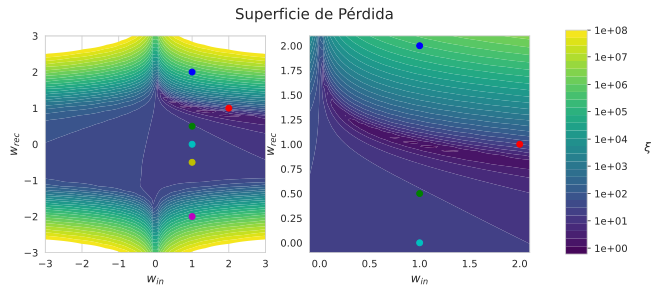

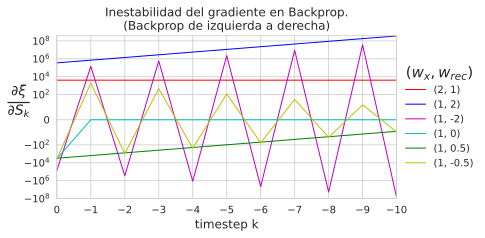

In [ ]:
# Obtiene y grafica la superficie de perdida con los marcadores
fig = get_loss_surface_figure(
    lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t), points)

# Plot de los gradientes cambiando con backpropagation
plot_gradient_over_time(points, get_grad_over_time)
plt.show()

# ¿Que podría pasar al usar gradiente descendiente normal?

<center> <img src='https://peterroelants.github.io/images/RNN_implementation/ExplodingGradient_Razvan.png' width=500> </center>


# Función de optimización RProp

Dada la inestabilidad de los gradientes normales, no podemos confiar en ellos para optimizar, podría ser que los gradientes se disparen y nunca converjan a algún mínimo, por lo que utilizaremos otra forma de modificar los pesos, el algoritmo RProp que se resume del siguiente modo:

- Se inicializa una $\Delta$ no-cero para actualizar los pesos.
- Para cada parámetro:
  - Si el signo del gradiente de los pesos cambia respecto a la iteración anterior:
    - Se multiplica el peso de actualización por $\eta^{-}$, con $\eta^{-} < 1$
  - Si no ocurre el cambio de signo:
    - Se mantiene el signo del peso, multiplicandose por $\eta^{+}$ con $\eta^{+} > 1$

- Se actualiza el peso en la dirección contraria de este valor mencionado arriba.



In [ ]:
def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    """
    Actualiza valores usando RProp en una iteración
    Args:
        X: data de entrada.
        t: etiquetas.
        W: pesos actuales de los parámetros.
        W_prev_sign: signo previo del gradiente W.
        W_delta: valores de RProp para actualizar (Delta).
        eta_p, eta_n: hiperparámetros RProp.
    Returns:
        (W_delta, W_sign): Deltas de actualización de pesis y el signo del 
                           último gradiente.
    """
    # Perform forward and backward pass to get the gradients
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:,-1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)  # Sign of new gradient
    # Update the Delta (update value) for each weight 
    #  parameter seperately
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

In [ ]:
# Perform Rprop optimisation

# Set hyperparameters
eta_p = 1.2
eta_n = 0.5

# Set initial parameters
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Update values (Delta) for W
W_sign = [0, 0]  # Previous sign of W

ls_of_ws = [(W[0], W[1])]  # List of weights to plot
# Iterate over 500 iterations
for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = update_rprop(
        X, t, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))  # Add weights to list to plot

print(f'Final weights are: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')

Final weights are: wx = 1.0014,  wRec = 0.9997


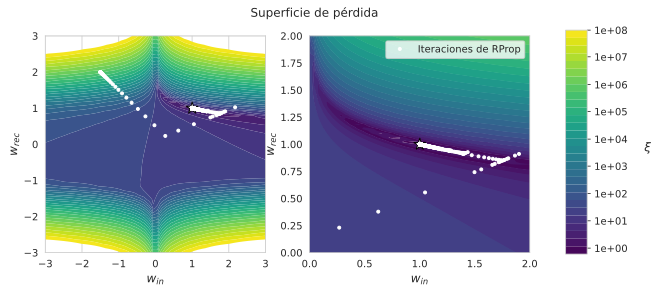

In [ ]:
# Visualizacion de la superficie de pérdida con los pesos en cada iteración 


def plot_optimisation(ls_of_ws, loss_func):
    """Grafica las iteraciones fr la optimización en la superficie de pérdida."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of loss function
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(
        -3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1 + 1)
    ax_1.plot(ws1, ws2, 'wo', markersize=3)
    ax_1.scatter(ws1[-1], ws2[-1], color='w', marker='*', s=150, edgecolors='k')
    ax_1.set_xlim([-3, 3])
    ax_1.set_ylim([-3, 3])
    # Plot zoom of loss function
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(
        0, 2, 0, 2, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2 + 1)
    ax_2.set_xlim([0, 2])
    ax_2.set_ylim([0, 2])
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2)
    ax_2.plot(ws1, ws2, 'wo', 
              label='Iteraciones de RProp', markersize=3)
    ax_2.scatter(ws1[-1], ws2[-1], color='w', marker='*', s=150, edgecolors='k')
    ax_2.legend()
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(
        surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel(
        '$\\xi$', fontsize=12, rotation=0, labelpad=20)
    cbar.set_ticklabels(
        ['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Superficie de pérdida', fontsize=12)
    plt.show()
    
# Plot the optimisation
plot_optimisation(
    ls_of_ws, lambda w1, w2: loss(forward_states(X, w1, w2)[:,-1] , t))
plt.show()
#

In [ ]:
test_inpt = np.asmatrix([[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]])
test_outpt = forward_states(test_inpt, W[0], W[1])[:,-1]
sum_test_inpt = test_inpt.sum()
print((
    f'Output Objetivo: {sum_test_inpt:d} vs Output Predicho: '
    f'{test_outpt[0]:.2f}'))

Output Objetivo: 5 vs Output Predicho: 5.00


# Versiones utilizadas

In [ ]:
# Python package versions used
!python --version
print(np.__version__)
print(sns.__version__)
print(matplotlib.__version__)

Python 3.7.13
1.21.6
0.11.2
3.2.2


In [ ]:
!pip install numpy==1.20.1

     |████████████████████████████████| 15.3 MB 14.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
